<a href="https://colab.research.google.com/github/Max-JI64/Kakao_Tech_Bootcamp/blob/main/Daily_class/25_10_27_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Layer

## 이미지 다운로드

In [1]:
# 필요한 라이브러리 임포트
import torch  # PyTorch 기본 라이브러리
import torch.nn as nn  # 신경망 모듈 (레이어, 손실 함수 등)
import torch.optim as optim  # 최적화 알고리즘 (SGD, Adam 등)
from torch.utils.data import DataLoader  # 데이터 배치 로딩
from torchvision import datasets, transforms  # 이미지 데이터셋 및 전처리

import matplotlib.pyplot as plt

In [2]:
# 데이터 변환 및 로드
# 이미지 전처리 파이프라인 정의
transform = transforms.Compose([
    transforms.ToTensor(),  # PIL 이미지를 PyTorch 텐서로 변환 (0-255 → 0-1)
    transforms.Normalize((0.5,), (0.5,))  # 정규화: {(픽셀 - 0.5) / 0.5} → [-1, 1] 범위로 변환
])

# FashionMNIST 학습 데이터셋 로드 (60,000개 이미지)
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# FashionMNIST 검증 데이터셋 로드 (10,000개 이미지)
val_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# 학습 데이터를 32개씩 배치로 묶어 로드 (shuffle=True: 매 에폭마다 순서 섞음)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 검증 데이터를 32개씩 배치로 묶어 로드 (shuffle=False: 순서 유지)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.59MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 152kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.84MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 18.8MB/s]


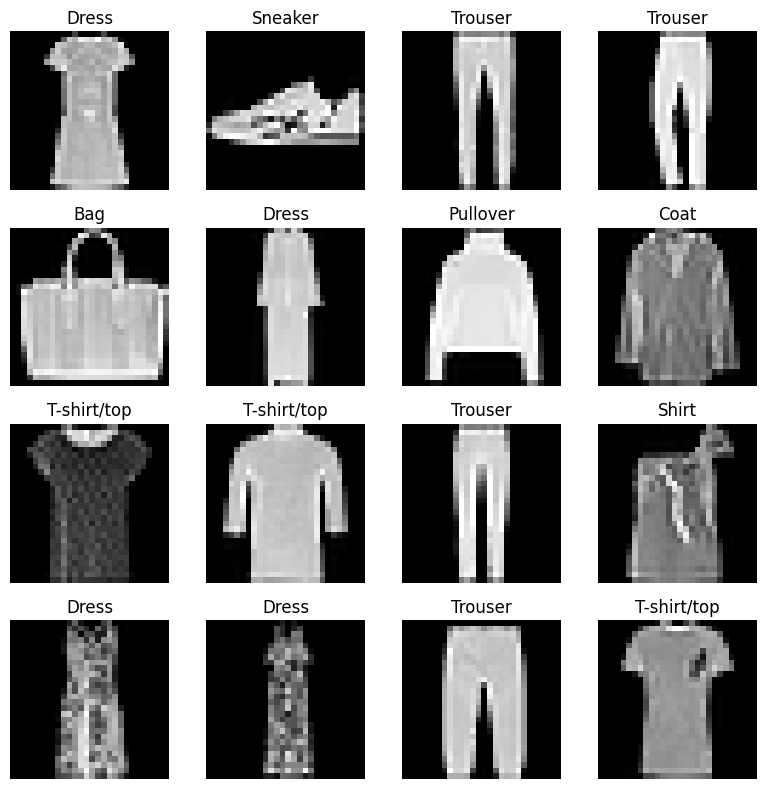

In [3]:
# 배치 이미지 시각화 with matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# FashionMNIST 클래스 이름 정의
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 학습 데이터에서 한 배치 가져오기
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 이미지 그리드로 시각화 (8개만 표시)
num_images = 16
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
axes = axes.flatten()

for i in range(num_images):
    # 정규화 역변환: [-1, 1] → [0, 1]
    img = images[i] / 2 + 0.5
    # 텐서를 넘파이 배열로 변환
    npimg = img.numpy()
    # 이미지 표시 (흑백이므로 squeeze로 채널 차원 제거)
    axes[i].imshow(npimg.squeeze(), cmap='gray')
    # 레이블 표시 (클래스 이름)
    axes[i].set_title(f'{class_names[labels[i]]}')
    # 축 숨기기
    axes[i].axis('off')

plt.tight_layout()
plt.show()

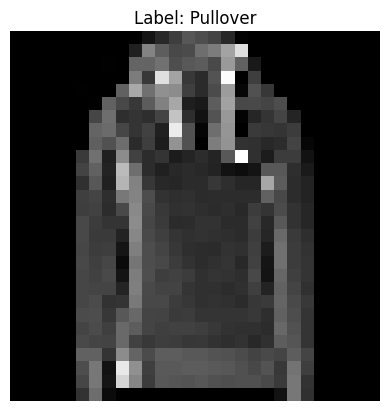

In [4]:
# 1개 데이터만 자세히 확인
dataiter = iter(train_loader)
images, labels = next(dataiter)
image = images[0]
label = labels[0]
# 정규화 역변환: [-1, 1] → [0, 1]
img = image / 2 + 0.5
# 텐서를 넘파이 배열로 변환
npimg = img.numpy()
# 이미지 표시 (흑백이므로 squeeze로 채널 차원 제거)
plt.imshow(npimg.squeeze(), cmap='gray')
# 레이블 표시 (클래스 이름)
plt.title(f'Label: {class_names[label]}')
plt.axis('off')
plt.show()

In [5]:
npimg.shape

(1, 28, 28)

## CNN 모델 생성

In [6]:
# CNN 모델 클래스 정의
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 첫 번째 합성곱 레이어: 입력 채널 1개(흑백) → 출력 채널 32개, 3x3 커널, padding=1로 크기 유지
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1) #또는 padding=same으로 이미지의 크기가 줄어들지 않게

        # 두 번째 합성곱 레이어: 입력 채널 32개 → 출력 채널 64개, 3x3 커널
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        # MaxPooling 레이어: 2x2 윈도우에서 최댓값 선택, stride=2로 크기 절반으로 축소
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # 첫 번째 완전연결층: 64채널 * 7x7 크기 = 3136개 입력 → 512개 출력
        self.fc1 = nn.Linear(64 * 7 * 7, 512) # 두번의 pool이후 특징맵의 크기가 28*28 -> 14*14 -> 7*7로 변환됨

        # 두 번째 완전연결층: 512개 입력 → 10개 클래스 출력 (FashionMNIST는 10개 카테고리)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # Conv1 → ReLU → MaxPool: (1, 28, 28) → (32, 28, 28) → (32, 14, 14)
        x = self.pool(torch.relu(self.conv1(x)))

        # Conv2 → ReLU → MaxPool: (32, 14, 14) → (64, 14, 14) → (64, 7, 7)
        x = self.pool(torch.relu(self.conv2(x)))

        # Flatten: (64, 7, 7) → (3136) - 2D 특징맵을 1D 벡터로 펼침
        x = x.view(-1, 64 * 7 * 7)

        # FC1 → ReLU: (3136) → (512)
        x = torch.relu(self.fc1(x))

        # FC2 (출력층): (512) → (10) - 각 클래스에 대한 점수
        x = self.fc2(x)
        return x

In [7]:
# 모델 인스턴스 생성
model = CNN()

In [8]:
# 손실 함수: 다중 클래스 분류를 위한 Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

# 최적화 알고리즘: Adam (학습률 0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
# 모델 훈련 함수

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # 지정된 에폭 수만큼 반복
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭마다 train과 val 단계 수행
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 학습 모드: Dropout, BatchNorm 활성화
                loader = train_loader
            else:
                model.eval()  # 평가 모드: Dropout, BatchNorm 비활성화
                loader = val_loader

            running_loss = 0.0  # 누적 손실
            running_corrects = 0  # 누적 정답 개수

            # 배치 단위로 데이터 처리
            for inputs, labels in loader:
                # 데이터를 GPU/CPU로 이동
                inputs, labels = inputs.to(device), labels.to(device)

                # 기울기 초기화 (이전 배치의 기울기 제거)
                optimizer.zero_grad()

                # 순전파 (forward pass)
                with torch.set_grad_enabled(phase == 'train'):  # train일 때만 기울기 계산
                    outputs = model(inputs)  # 모델 예측
                    _, preds = torch.max(outputs, 1)  # 가장 높은 점수의 클래스 선택
                    loss = criterion(outputs, labels)  # 손실 계산

                    # train 단계에서만 역전파 및 가중치 업데이트
                    if phase == 'train':
                        loss.backward()  # 역전파: 기울기 계산
                        optimizer.step()  # 가중치 업데이트

                # 통계 누적
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # 에폭 평균 손실 및 정확도 계산
            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = running_corrects.double() / len(loader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

    return model

In [10]:
# GPU 사용 설정 (CUDA가 가능하면 GPU, 아니면 CPU 사용)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# 모델을 선택한 디바이스로 이동
model = model.to(device)

# 모델 훈련 시작 (10 에폭)
model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10)

Using device: cuda:0
Epoch 0/9
----------
train Loss: 0.3795 Acc: 0.8619
val Loss: 0.3036 Acc: 0.8927

Epoch 1/9
----------
train Loss: 0.2395 Acc: 0.9115
val Loss: 0.2649 Acc: 0.9000

Epoch 2/9
----------
train Loss: 0.1919 Acc: 0.9283
val Loss: 0.2475 Acc: 0.9126

Epoch 3/9
----------
train Loss: 0.1536 Acc: 0.9428
val Loss: 0.2572 Acc: 0.9139

Epoch 4/9
----------
train Loss: 0.1215 Acc: 0.9547
val Loss: 0.2573 Acc: 0.9152

Epoch 5/9
----------
train Loss: 0.0935 Acc: 0.9645
val Loss: 0.2645 Acc: 0.9208

Epoch 6/9
----------
train Loss: 0.0733 Acc: 0.9731
val Loss: 0.2899 Acc: 0.9186

Epoch 7/9
----------
train Loss: 0.0554 Acc: 0.9795
val Loss: 0.3247 Acc: 0.9224

Epoch 8/9
----------
train Loss: 0.0449 Acc: 0.9834
val Loss: 0.3994 Acc: 0.9158

Epoch 9/9
----------
train Loss: 0.0388 Acc: 0.9864
val Loss: 0.4136 Acc: 0.9144



In [12]:
# 모델 평가
model.eval()  # 평가 모드로 전환
correct = 0  # 정답 개수
total = 0  # 전체 샘플 개수

# 평가 시에는 기울기 계산 불필요 (메모리 절약 및 속도 향상)
with torch.no_grad():
    for inputs, labels in val_loader:
        # 데이터를 디바이스로 이동
        inputs, labels = inputs.to(device), labels.to(device)
        # 모델 예측
        outputs = model(inputs)
        # 가장 높은 점수의 클래스 선택
        _, predicted = torch.max(outputs.data, 1)
        # 전체 샘플 수 누적
        total += labels.size(0)
        # 정답 개수 누적
        correct += (predicted == labels).sum().item()

# 정확도 계산 (백분율)
accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")

# 샘플 데이터로 모델 예측 테스트
# 검증 데이터의 처음 5개 이미지 가져오기
sample_input = val_dataset.data[:5].unsqueeze(1).float().clone().detach().to(device)
# 예측값 계산 (기울기 추적 안 함)
predictions = model(sample_input).detach().cpu().numpy()
print("Predictions: ", predictions)  # 각 클래스에 대한 점수 출력
print("True labels: ", val_dataset.targets[:5].numpy())  # 실제 정답 레이블 출력

Validation Accuracy: 91.44%
Predictions:  [[ -210.9574  -1418.9352  -2892.7832  -2983.563   -2364.5833     76.46934
  -1973.821    -495.36707  -893.95245  -130.71448]
 [-1638.3016  -4120.4536   1572.6658   -960.7214  -3228.2107  -3614.7322
   -611.6578  -5249.308   -3463.3782  -4123.2773 ]
 [-2449.4229   2948.759   -3605.5444  -1590.589   -1445.2667  -3432.3506
  -3144.1904  -4431.8335  -4053.6348  -6899.424  ]
 [-1747.9941   1815.2565  -2121.5452   -966.07104 -1068.7668  -3036.1008
  -2622.8254  -3715.1597  -3672.5508  -5164.0776 ]
 [ -353.70673  -950.46954  -499.64777 -1017.6761   -747.1507  -1771.3773
    396.3834   -953.7637  -1097.9836  -1069.945  ]]
True labels:  [9 2 1 1 6]


In [13]:
for i in predictions:
    print(class_names[i.argmax()])

Sandal
Pullover
Trouser
Trouser
Shirt


In [14]:
# confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

all_preds = []
all_labels = []

for inputs, labels in val_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

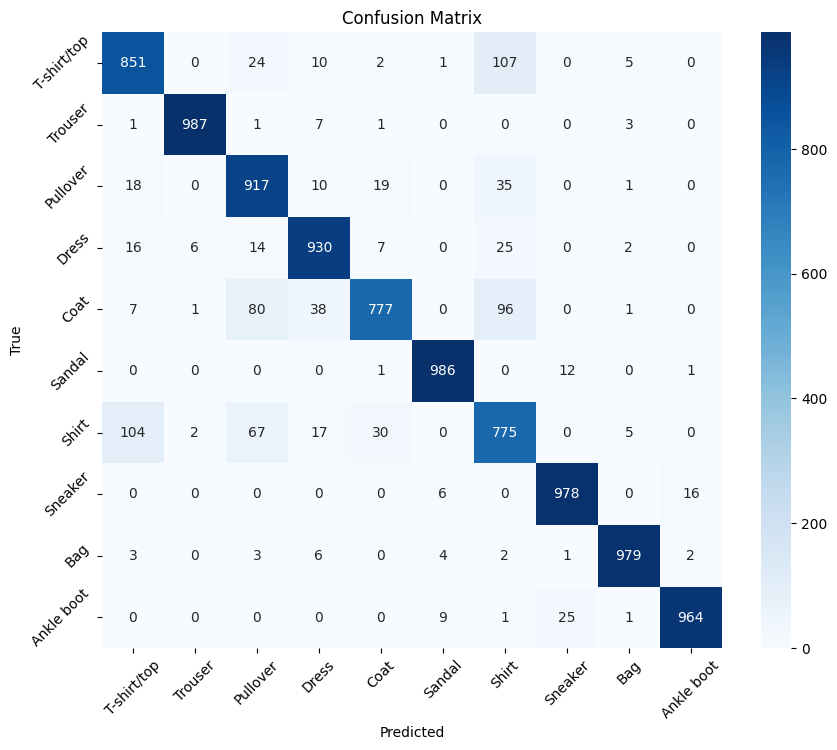

In [15]:
# 혼동 행렬 계산
cm = confusion_matrix(all_labels, all_preds)

# 혼동 행렬 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()

In [16]:
# report generation
from sklearn.metrics import classification_report
report = classification_report(all_labels, all_preds, target_names=class_names)
print(report)

              precision    recall  f1-score   support

 T-shirt/top       0.85      0.85      0.85      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.83      0.92      0.87      1000
       Dress       0.91      0.93      0.92      1000
        Coat       0.93      0.78      0.85      1000
      Sandal       0.98      0.99      0.98      1000
       Shirt       0.74      0.78      0.76      1000
     Sneaker       0.96      0.98      0.97      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000

